In [1]:
#!/usr/bin/env python
# coding: utf-8

# Отключаем графический ускоритель
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# Импортируем требуемые библиотеки
import numpy as np
import pandas as pd
import matplotlib as mpl
#import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
#from keras.utils import np_utils
#from sklearn.model_selection import train_test_split

from lib.graphplot import *
from lib.mathtool import *
from lib.processingutils import *

In [2]:
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12, 6)

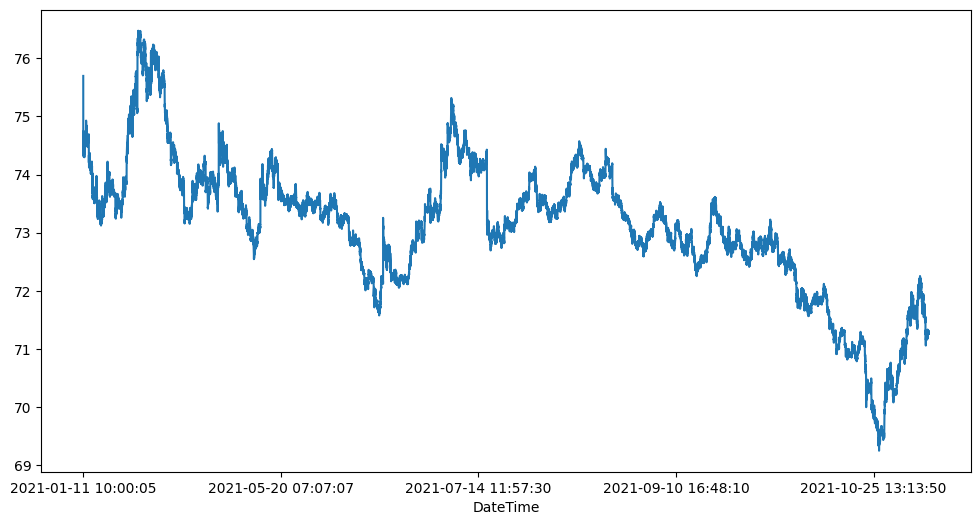

In [3]:
#csv_path = '~/notebook_server/data/USDRUB.csv'D:/Work/PROGR/BIG_DATA/DATA/USDRUB+++.csv
csv_path = 'D:/Work/PROGR/BIG_DATA/DATA/USDRUB+++.csv'
usdrub = pd.read_csv(csv_path)
features_considered = ['LastPriceKF', 'dTime']
uni_data = usdrub[features_considered]
uni_data.index = usdrub['DateTime']
uni_data = uni_data.iloc[1:] # исключаем первую(нулевую выборку)
uni_data.head()
uni_data['LastPriceKF'].plot(subplots=True)

uni_data = uni_data.values

In [4]:
# Устанавливаем параметры генерации данных
print('Нормализация данных')
dataset_norm = dataset_normalization(uni_data)
#plt.hist(dataset_norm[:,0], facecolor='blue', alpha=0.5)
#plt.show()

Нормализация данных


In [5]:
univariate_past_history = 200
univariate_future_target = 1

# Генерируем данные для нейросети
uni_data_all = reform_data(dataset=dataset_norm, 
                            history_size=univariate_past_history,
                            target_size=univariate_future_target,
                            shuffle=False)

Nsamples = uni_data_all.shape[0]
print(f'количество выборок: {Nsamples}')

TRAIN_SPLIT = 0.80
TRAIN_SPLIT = int(Nsamples * TRAIN_SPLIT)

x_uni, y_uni = preparate_data(dataset=uni_data_all, 
                                history_size=univariate_past_history,
                                target_size=univariate_future_target)

x_train_uni = x_uni[:TRAIN_SPLIT]
y_train_uni = y_uni[:TRAIN_SPLIT]

x_val_uni = x_uni[TRAIN_SPLIT:]
y_val_uni = y_uni[TRAIN_SPLIT:]
#x_train_uni, x_val_uni, y_train_uni, y_val_uni = train_test_split(x_uni, y_uni, test_size=(1-TRAIN_SPLIT))

Подготовка данных: 100%|███████████████████████████████| 2139030/2139030 [00:41<00:00, 52041.63it/s]


количество выборок: 2085430


Подготовка выходных данных: 100%|█████████████████████| 2085430/2085430 [00:04<00:00, 476847.25it/s]


Загрузка модели 1_0_1


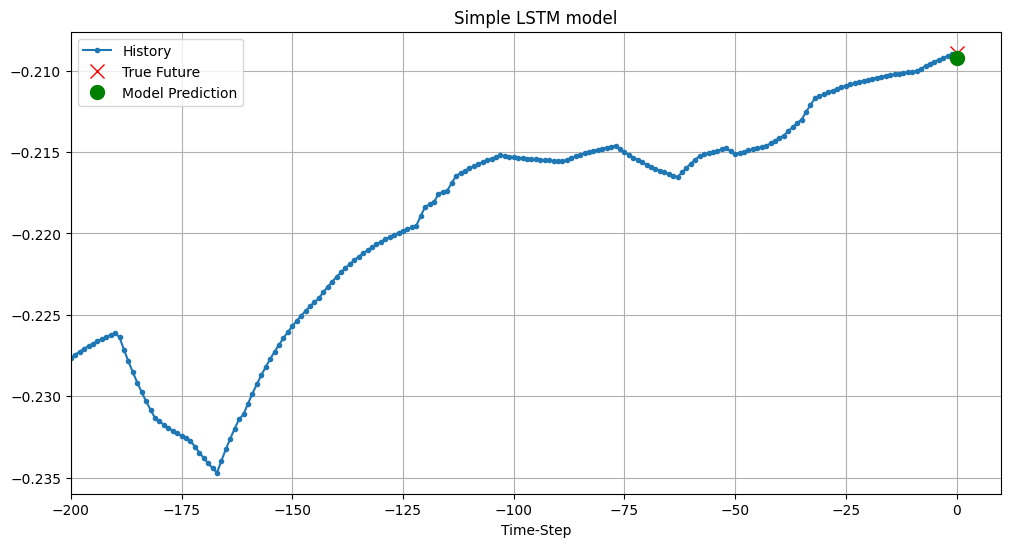

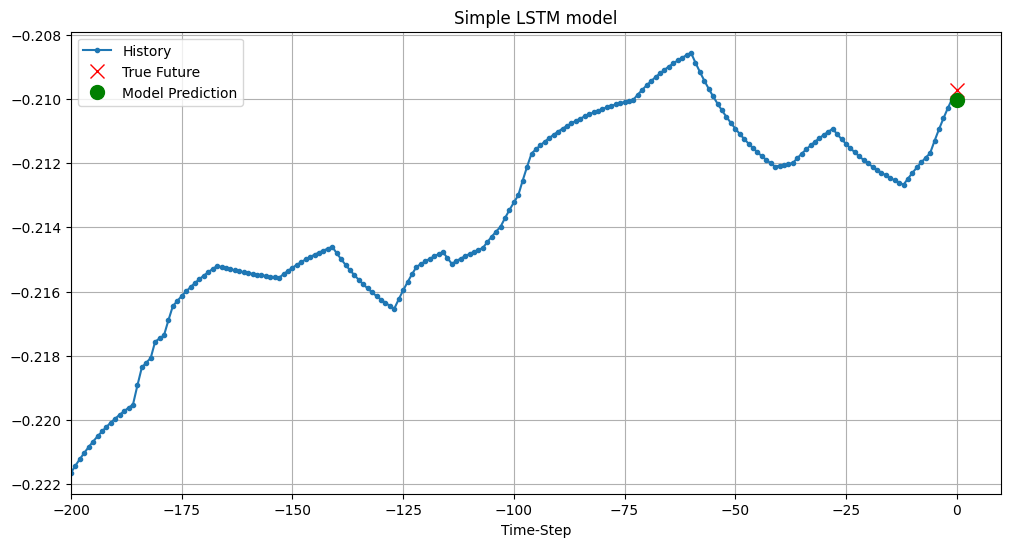

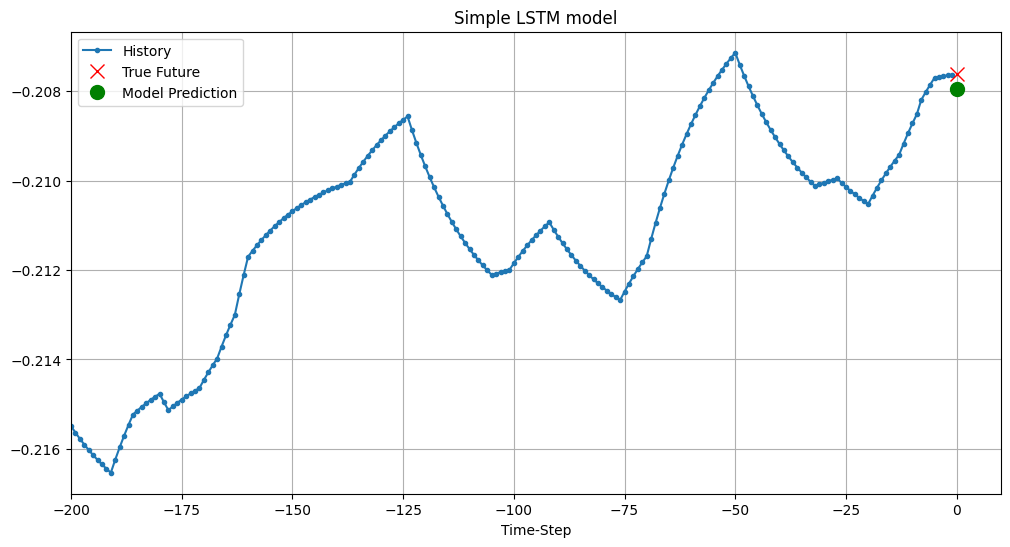

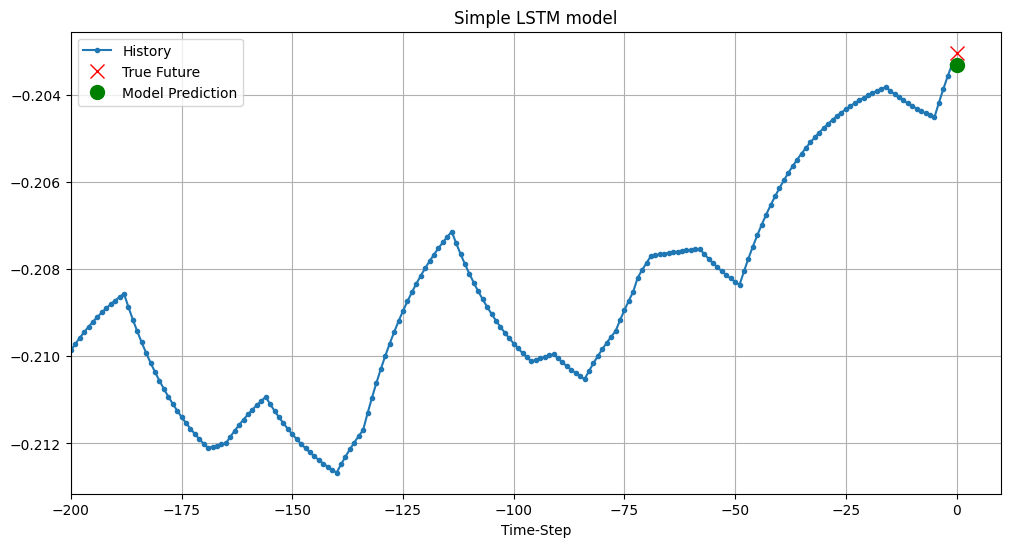

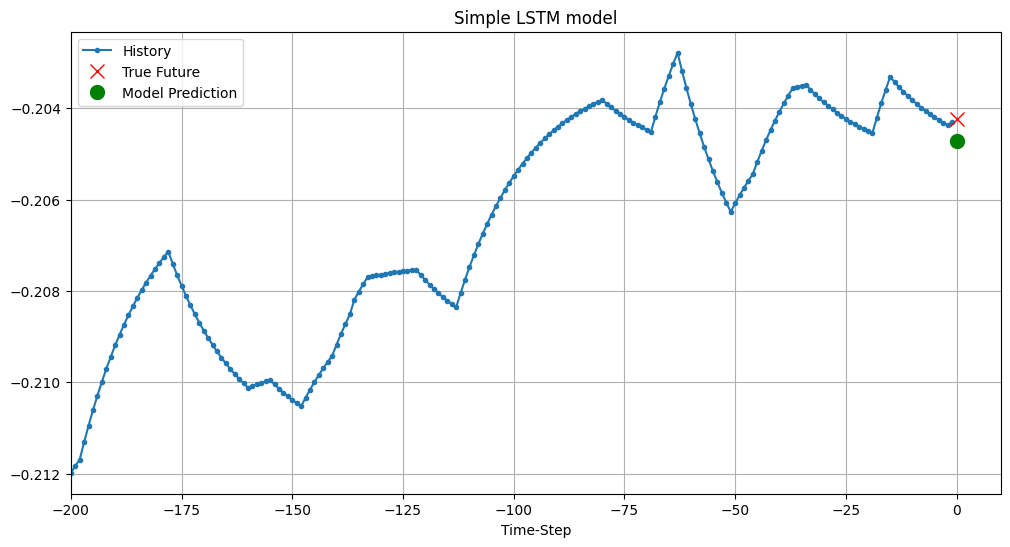

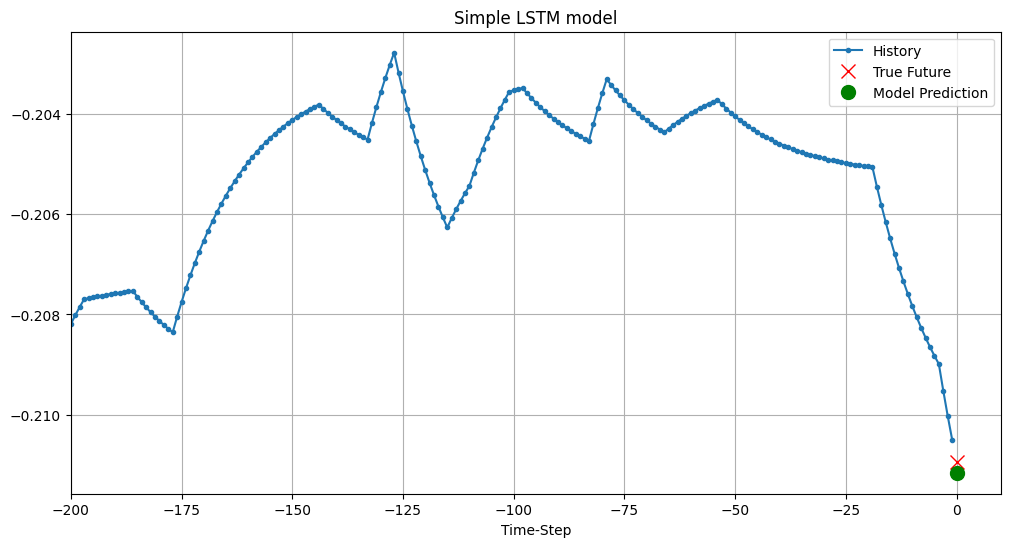

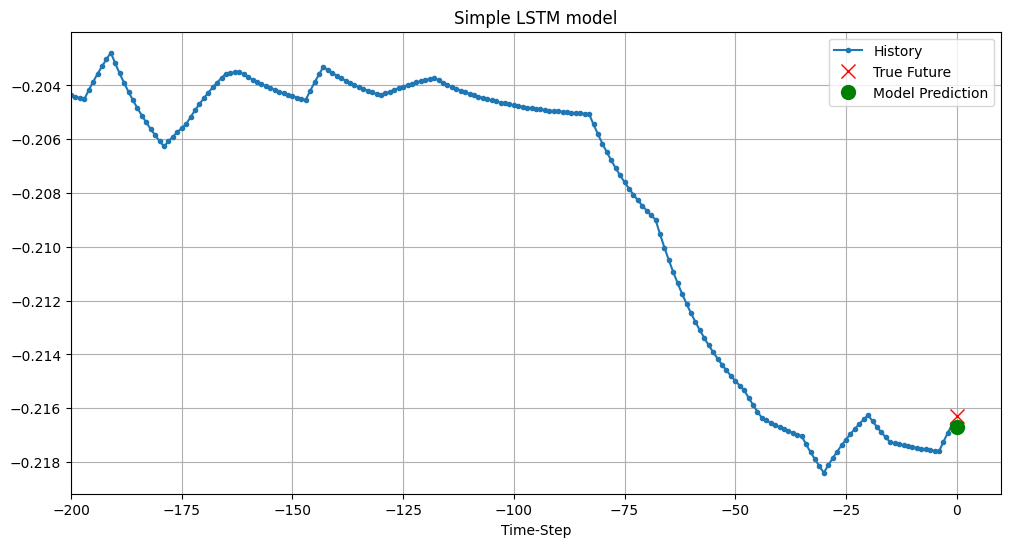

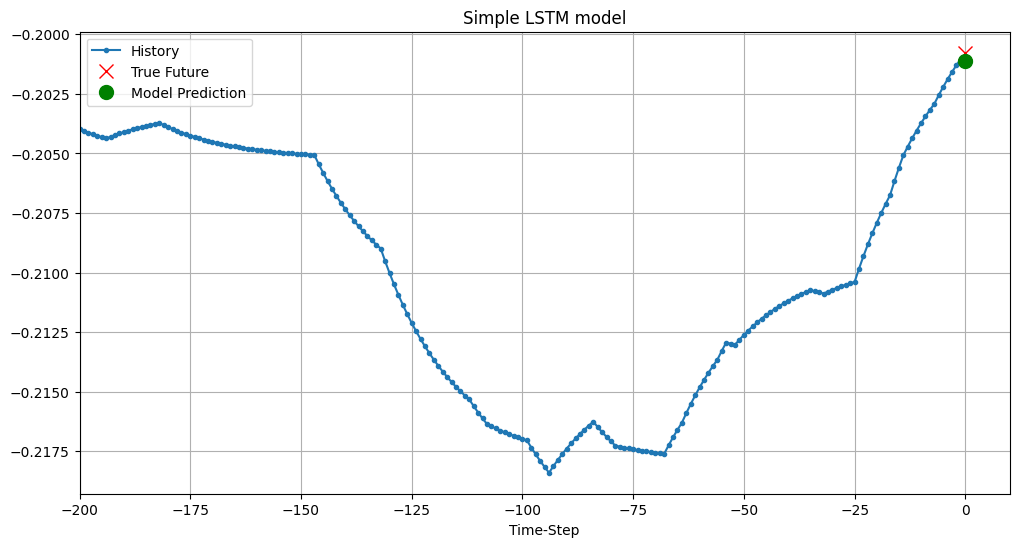

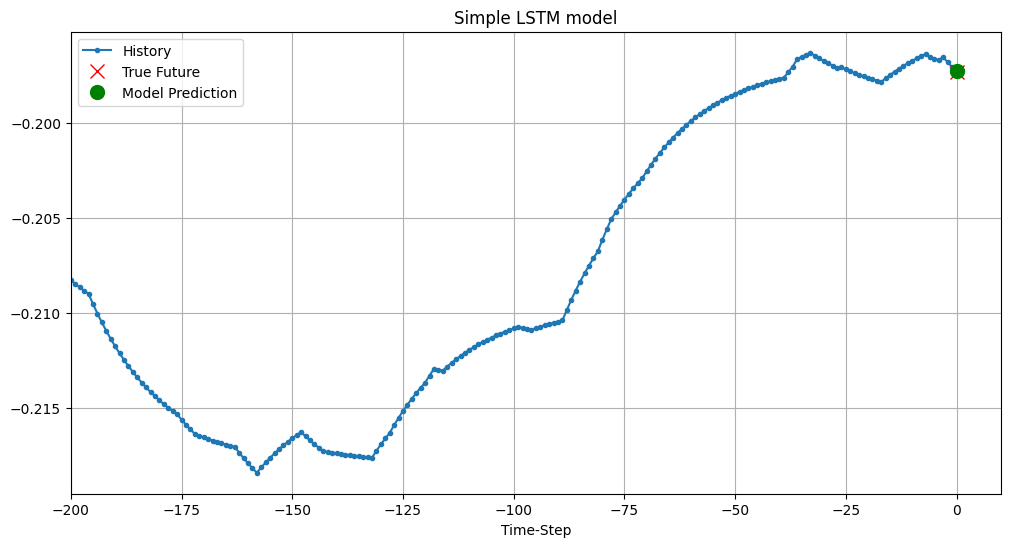

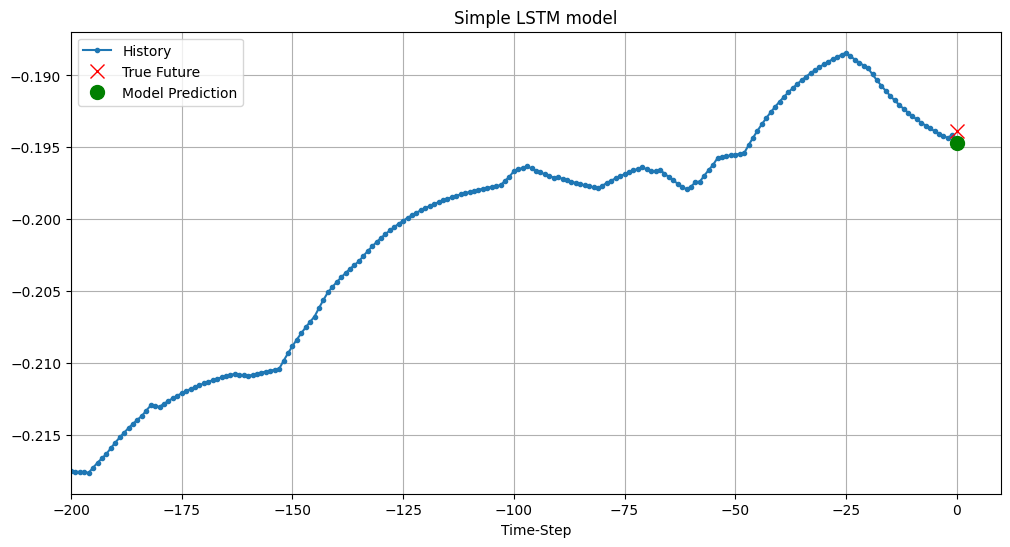

In [15]:
BATCH_SIZE = 64
BUFFER_SIZE = 1024

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

VER = '1_0_1'
print(f'Загрузка модели {VER}')
#simple_lstm_model.save(f'~/notebook_server/result/{VER}')
simple_lstm_model = keras.models.load_model(f'D:/Work/PROGR/BIG_DATA/TradeModel/NN/result/{VER}')

for x, y in val_univariate.take(10):
    #rand_values = random.randint(0, x_train_uni.shape[0])
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

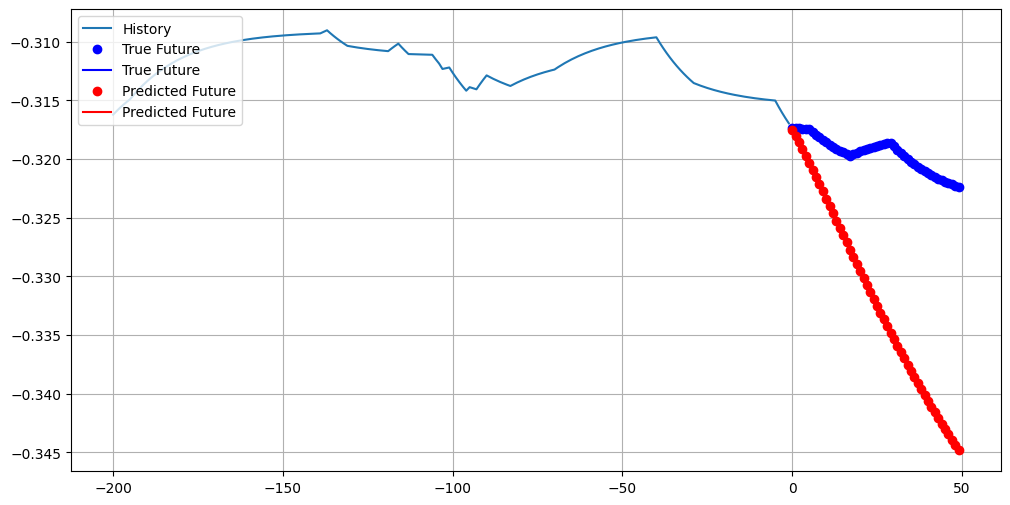

In [18]:
first_init = True

# Количество точек предсказания
num_point_prediction = 50
# Нулевые массивы для заполнения данные
predictable_sample = np.zeros((BATCH_SIZE, 200, 1))
history_data = np.array([])
true_future = np.array([]) 
predicted_future = np.array([])
pre_window = np.array([])

offset = 0

for x, y in val_univariate.take(28):
    history_value = x
    true = y

#print(f'history_value: {history_value}')
history_sample = history_value[offset].numpy()
pre_window = np.append(pre_window, history_sample)
#print(f'history[0].numpy(): {history[0].numpy()}')
#print(f'predict_window: {pre_window}')

for num in range(num_point_prediction):
    # Из массива формируем выборку для предсказания
    true_future = np.append(true_future, true[num+offset])
    
    if first_init:
        predictable_sample[0] = history_sample #history_value[num+offset].numpy()
        first_init = False
        #print(f'{num}. Historical data')
    else:
        predictable_sample[0] = pre_window
        #print(f'{num}. Calculated data')
    
    # Вычисляем предсказание
    predicted_sample = simple_lstm_model.predict(predictable_sample)[0]
    predicted_future = np.append(predicted_future, predicted_sample)

    # Добавляем в конец списка предсказанный элемент
    pre_window = np.append(pre_window, predicted_sample)
    # Удаляем первый элемент (сохраянем размернойсть массива)
    pre_window = np.delete(pre_window, 0)
    pre_window = np.reshape(pre_window, (pre_window.shape[0], 1))

#print(f'true_future: {true_future}')
#print(f'predicted_future: {predicted_future}')
multi_step_plot(history_sample, true_future, predicted_future)
